# 四. Logit regression

## 1. 模型 

考虑一个二分类任务，其生产标记$y\in \{0,1\}$，而线性回归模型产生的预测值$z=\mathbf{\omega^Tx+b}$是实数，于是需将$z$转换为0/1值。直观地，可以考虑"单位阶跃函数"
$$
\begin{equation}
y=\begin{cases}
0,z<0;\\
0.5,z=0;\\
1,z>0.
\end{cases}
\end{equation}
$$
即若预测值$z$大于0则判为正例。显然，单位阶越函数是不连续函数，因此退而使用有更好性质的对数几率函数（`logistic function`）:
$$
y=\frac{1}{1+e^{-z}}.
$$
显然对数几率函数可以将`z`值转换为一个接近0或1的值，且在$z=0$附近变化很陡。

将$z=\mathbf{\omega^Tx+b}$代入对数几率函数，可得
$$
y=\frac{1}{1+e^{-\mathbf{\omega^Tx+b}}}.
$$
进而转换为
$$
\mathrm{ln}\frac{y}{1-y}=\mathbf{\omega^Tx+b}.
$$
若将$y$视为样本$\mathbf{x}$作为正例的可能性，则$1-y$是其反例可能性，两者比值为
$$
\frac{y}{1-y}
$$
称为几率（`odd`），反映了 **$x$作为正例的相对可能性**。对几率取自然对数则可得对数几率（`log odds`, 也称为`logit`）
$$
\mathrm{ln}\frac{y}{1-y}
$$

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def f(z):
    if z < 0:
        return 0
    elif z == 0:
        return 0.5
    else:
        return 1

def g(z):
    return 1/(1+np.exp(-z))

函数的向量化

In [3]:
v_f = np.vectorize(f)
v_g = np.vectorize(g)

In [4]:
z = np.linspace(-5, 5, num=200)
y1 = v_f(z)
y2 = v_g(z)

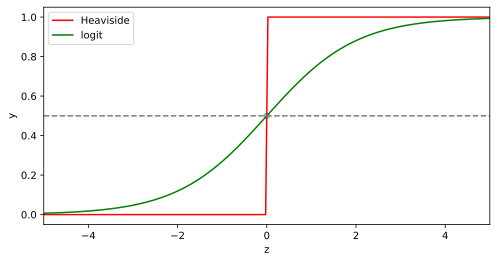

In [5]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z, y1, 'r-', label='Heaviside')
ax.plot(z, y2, 'g-', label='logit')
ax.scatter([0], [0.5], s=30, alpha=0.5)
ax.hlines(0.5, -5, 5, color='grey', linestyles='--')
ax.set_xlim([-5, 5])
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.legend()
# plt.savefig("../pictures/5.2-logit&heaviside.svg")

## 2. 参数学习

通过“极大似然法”来估计$\omega$和$b$，给定数据集$\{(x_i,y_i)\}^m_{i=1}$，最大化对数似然率
$$
\max_{w,b} \mathbf{ll(w,b)}=\sum_{i=1}^m \mathrm{ln}p(y_i|\mathbf{x_i;w,b})
$$
即令每个样本属于其真实标记的概率越大越好。上式又等价于最小化负对数似然率
$$
(\omega, b)^* = \mathrm{argmin_{w,b}} \mathbf{nll(w,b)}=\sum_{i=1}^m\left(-y_i(\omega^Tx_i+b)+\mathbf{ln}(1+e^{\omega^Tx_i+b})\right)
$$

令$\beta = (\omega, b), \hat{x}_i = (x_i, 1)$，则有
$$
\beta^* = \mathrm{argmin_{\beta}} \mathbf{nll(\beta)}=\sum_{i=1}^m\left(-y_i \hat{x}_i \beta^T+\mathbf{ln}(1+e^{\beta^T \hat{x}_i})\right)
$$

对$\beta$求梯度可得
$$
\mathbf{\frac{\partial nll}{\partial \beta}}=\sum_{i=1}^m(-y_i+\frac{1}{1+e^{-\beta^T\hat{x}_i}})\hat{x}_i
$$
令$\hat{y}_i=\frac{1}{1+e^{-\beta^T\hat{x}_i}}$，则有
$$
\begin{aligned}
\mathbf{\frac{\partial nll}{\partial \beta}}&=\sum_{i=1}^m(\hat{y}_i-y_i)\hat{x}_i \\
&=(\hat{y}-y)^T \hat{X} 
\end{aligned}
$$

## 3. 基于`torch`实现`Logit`回归

In [6]:
# logit函数
def logit(X, beta, bias=True):
    '''
    X: m * d m个样本，每个样本d维特征
    beta: d+1 维, d维特征权重+1维截距
    bias: 指定是否含截距项
    '''
    if bias:
        hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)
        return 1 / (1 + torch.exp(-hat_X@beta.reshape(-1, 1)))
    else:
        return 1 / (1 + torch.exp(-X@beta.reshape(-1, 1)))  # torch.sigmoid(X@beta.reshape(-1, 1))

示例数据

In [7]:
true_beta = torch.FloatTensor([4, -2, 1]).reshape(-1, 1)
x = torch.randn(size=(1000, 2)).float()

# 生成数据集
z = logit(x, true_beta)  # 为正例的概率
y = z >= 0.5  # 生成True或False
y = y.float()  # 注意要转换为浮点数，否则后面迭代时报错

x_train = x[:int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]

y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

- 梯度下降

In [8]:
# 负对数似然函数
def negloglikelihood(X, y, beta, bias=True):
    '''
    X: m * d m个样本，每个样本d维特征
    y: m * 1 m个标签
    beta: d+1 维, d维特征权重+1维截距
    '''
    hat_y = logit(X, beta, bias=bias)
    llike = -y.reshape(1, -1)@hat_y + torch.ones_like(hat_y).reshape(1, -1)@torch.log(1 + torch.exp(hat_y))
    return llike

In [9]:
def precision(beta, feature, true_label):
    '''
    预测精度
    '''
    z = logit(feature, beta)  # 计算对数几率
    y = (z >= 0.5).float()  # 大于等于0.5的为1
    return torch.sum(y == true_label).numpy() / len(y)

In [10]:
def gradident_descendent_logit(X, y, lr=0.05, bias=True):
    if bias:
        hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)
    else:
        hat_X = X

    beta = torch.randn(hat_X.shape[1], 1)  # 增广权重
    loss = negloglikelihood(X, y, beta, bias=bias)
    trace_loss = loss.numpy()
    while True:
        err = logit(X, beta, bias=bias) - y
        beta = beta - lr * hat_X.t() @ err
        loss = negloglikelihood(X, y, beta, bias=bias)
        loss = loss.numpy()
        trace_loss = np.concatenate([trace_loss, loss])
        if np.abs((trace_loss[-1] - trace_loss[-2]) / trace_loss[-1]) < 1e-5:
            break
            
    return beta.squeeze(), trace_loss

In [12]:
est_beta, _ = gradident_descendent_logit(x_train, y_train, lr=0.1)
est_beta

tensor([ 37.7456, -19.0132,   9.4213])

In [13]:
train_precision = precision(est_beta.reshape(-1, 1), x_train, y_train)
train_precision

1.0

In [14]:
test_precision = precision(est_beta.reshape(-1, 1), x_test, y_test)
test_precision

1.0

- 利用`torch`自动求导机制实现小批量随机梯度下降

In [15]:
def mini_batch_sgd(X, y, loss_func, beta, bias=True, num_epochs=50, batch_size=20, lr=0.05):
    dataset = TensorDataset(X, y)
    data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        for t_x, t_y in data_iter:
            l = loss_func(t_x, t_y, beta, bias=bias)        
            l.backward()  # 计算损失函数在 [w,b] 上的梯度
            beta.data.sub_(lr*beta.grad/batch_size)
            beta.grad.data.zero_()
            
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():  # 不计算梯度，加速损失函数的运算
                train_l = loss_func(t_x, t_y, beta, bias=bias)  # 最近一次的负对数似然率
                est_beta = [u[0] for u in beta.detach().numpy()]  # detach得到一个有着和原tensor相同数据的tensor
                train_accu_ratio = precision(beta, X, y)
                print(f'epoch {epoch + 1}, loss: {train_l.numpy()[0][0]:.4f}')
                print(f'    train accuracy: {train_accu_ratio}')
            
    return est_beta, train_l.numpy()

In [28]:
params = torch.randn(x_train.shape[1] + 1, 1)
params.requires_grad_()  # 初始化参数
mini_batch_sgd(x_train, y_train, negloglikelihood, params, num_epochs=100, lr=0.03)

epoch 10, loss: 13.6625
    train accuracy: 0.88875
epoch 20, loss: 11.1928
    train accuracy: 0.91
epoch 30, loss: 10.2702
    train accuracy: 0.915
epoch 40, loss: 10.6225
    train accuracy: 0.9225
epoch 50, loss: 10.6153
    train accuracy: 0.92625
epoch 60, loss: 9.6858
    train accuracy: 0.92875
epoch 70, loss: 12.2136
    train accuracy: 0.935
epoch 80, loss: 10.7528
    train accuracy: 0.93625
epoch 90, loss: 11.0286
    train accuracy: 0.93625
epoch 100, loss: 11.2221
    train accuracy: 0.93875


([3.2633297, -1.7861056, 0.20630325], array([[11.222072]], dtype=float32))

## 4.多分类学习

现实中常遇到多分类学习任务。有些二分类学习方法可以直接推广到多分类，例如，将`Logit`模型推广为`SoftMax`模型。但在更多情形下，我们是基于一些基本训练策略，利用二分类学习器来解决多分类问题。

考虑N个类别$C_1,C_2,...,C_N$，多分类学习的基本思路是“拆解法”，即将多分类任务拆分为若干个二分类任务求解。具体而言：先对问题进行拆分，然后为拆出的每个二分类任务训练一个分类器；在测试时，对这些分类器的预测结果进行集成以获取最终的多分类结果。这里的关键是如何对多分类任务进行拆分，以及如何对多个分类器进行集成。

最经典的拆分策略有三种：**“一对一”（one v.s. one, 简称OvO）** 、**“一对其余”（one v.s. rest, 简称OvR）** 和 **“多对多”（many v.s. many, 简称MvM）**。

### 4.1 one v.s. one

给定数据集$D=\{(x_1,y_1),(x_2,y_2),...,(x_m,y_m)\},y_i\in\{C_1,C_2,...,C_N\}$. OvO将这N个类别两两配对，从而产生$N(N-1)/2$个二分类任务。

OvO将为区分类别$C_i$和$C_j$训练一个分类器，该分类器将$C_i$类样例作为正例，$C_j$类样例作为反例。在测试阶段，新样本将同时提交给所有分类器，于是我们将得到$N(N-1)/2$个分类结果，最终结果可通过投票产生：**即把被预测得最多的类别作为最终分类结果**。

### 4.2 one v.s. rest

OvR每次将一个类的样例作为正例、所有其他类的样例作为反例来训练N个分类器。在测试时若仅有一个分类器预测为正类，则对应的类别标记作为最终分类结果。若有多个分类器预测为正类，则通常考虑各分类器的预测置信度，选择置信度最大的类别标记作为分类结果。

容易看出，相对于OvO，OvR只需要训练N个分类器，而OvO则需要训练$N(N-1)/2$个分类器，因此，OvO的存储开销和测试时间开销通常比OvR更大。但在训练时，OvR的每个分类器均使用全部训练样例，而OvO的每个分类器仅用到两个类的样例。因此，在类别很多时，OvO的训练时间开销通常比OvR更小。至于预测性能，则取决于具体的数据分布，在多数情形下两者差不多。

### 4.3 many v.s. many

MvM是每次将若干个类作为正类，若干个其他类作为反类。显然，OvR和OvO是MvM的特例。MvM的正、反类构造必须有特殊的设计，不能随意选取。有一种常用的MvM技术：“纠错输出吗”(Error Correcting Output Codes, ECOC)。

ECOC将编码的思想引入类别拆分，尽可能在解码过程中具有容错性。ECOC工作工程主要分类两步：
- 编码： 对N个类别做M次划分，每次划分将一部分类别作为正类，一部分划分为反类，从而形成一个二分类训练集；从而产生M个训练集，训练出M个分类器。
- 解码：M个分类器分别对测试样本进行预测，这些预测标记组成一个编码。将这个预测编码与每个类别各自的编码进行比较，返回其中距离最小的类别作为最终预测结果。

类别划分通过“编码矩阵”（coding matrix）指定。编码矩阵有多种形式，常见的主要有二元码(Dietterich & Bakiri, 1995)和三元码(Allwein et al., 2000)。前者将每个类别分别指定为正类和反类，后者在正、反类之外，还可指定“停用类”。

## 5. 类别不平衡问题

目前为止，我们学习的分类学习方法都有一个共同的基本假设，即不同类别的训练样例数目相当。如果不同类别的训练样本数目稍微有差别，通常影响不大。但是，如果差别很大，则会对学习过程造成困扰。例如有99个反例，但正例只有1个，那么学习方法只需要返回一个永远将新样本预测未反例的学习器，就能达到99%的精度；然而这样的学习器往往没有价值，因为它不能预测任何正例。

**类别不平衡(class-imbalance)** 就是指分类任务中不同类别的训练样例数目差不很大的情况。不失一般性，假定正类样例较少，反类样例较多。在现实的分类学习分类任务中，经常会遇到类别不平衡，例如在通过拆分法解决多分类问题时，即使原始问题中不同类别的训练样例数目相当，在使用OvR, MvM策略后产生的二分类任务仍可能出现类别不平衡现象，因此有必要了解类别不平衡性处理的基本方法。

从线性分类器的角度讨论容易理解，在用$y=w^Tx+b$对新样本进行分类时，事实上是在用预测出的y值与一个阈值进行比较，例如通常在$y>0.5$时判别为正例，否则为反例。y实际上表达了正例的可能性，几率$\frac{y}{1-y}$则反映了正例可能性与反例可能性的比值，阈值设置为0.5表明分类器认为真实正、反例可能性相同，则分类器的决策规则为
$$
\text{如果 }\frac{y}{1-y}>1, \text{那么预测为正例}
$$
然而，当训练集中正、反例的数量不同时，令$m^+$表示正例数目，$m^-$表示反例数目，则观测几率为$\frac{m^+}{m^-}$，由于我们通常假设训练集是真实样本总体的无偏采样，因此观测几率就代表了真实几率。于是，只要分类器的预测几率高于观测几率就应判定为正例，即
$$
\text{如果 }\frac{y}{1-y}>\frac{m^+}{m^-}, \text{那么预测为正例}
$$

因此，需要将预测值调整为
$$
\frac{y'}{1-y'}=\frac{y}{1-y}\times\frac{m^-}{m^+}
$$
以上过程称为“再平衡(rebalance)”。这就是类别不平衡学习的一个基本策略---**“再缩放”（rescaling）**。
> 阈值仍然为0.5

再缩放的思想虽简单，但实际操作却并不平凡，因为 **“训练集是真实样本总体的无偏采样”** 这个假设往往不成立，也就是说，我们未必能有效地基于训练集观测几率来推断出真实几率。现有技术大体上有三类做法；

- “欠采样”（undersampling）: 去除一些反例使得正、反例数目接近，然后再进行学习
- “过采样”（oversampling）：增加一些正例使得正反例数目接近，然后再进行学习
- “阈值移动”（threshold-moving）：同再缩放策略

欠采样的时间开销远小于过采样，因为前者丢弃了很多反例，使得分类器训练集远小于初始训练集，而过采样法则增加了很多正例，使得训练集大于初始训练集。

过采样法不能简单地对初始正例样本进行重复采样，否则会招致严重的过拟合；过采样法的代表性算法`SMOTE`(chawlaet al., 2002)通过对训练集中的正例进行插值来产生额外的正例。

欠采样法如果随机丢弃反例，可能丢失一些重要信息；欠采样法的代表性算法`EasyEnsemble (Liu et al., 2009)`则是利用集成学习机制，将反例划分为若干个集合供不同学习期使用，这样对每个学习期来看都进行了欠采样，但在全局来看却不会丢失重要信息。

## 参考资料
1. 周志华. 机器学习. 2019.
2. Christopher M. Bishop. Pattern recognition and machine learning. 2006.
3. [阿斯顿·张、李沐、扎卡里 C. 立顿、亚历山大 J. 斯莫拉等. 动手学深度学习. 2020.](https://github.com/d2l-ai/d2l-zh)